# Cloud forest demo

This notebook demonstrates how to work with contemporary cloud-based spatial analysis and indexing tools. It accompanies [this blog post](https://salo.ai/blog/2021/01/cfo-cloud). We'll work with:

- Cloud-Optimized Geotiffs (COG)
- Google Earth Engine
- SpatioTemporal Asset Catalogs (STAC)

We'll also describe integrations between these tools and the CFO API.

If you have conda installed, you can run the following to load this notebook:

```bash
git clone https://github.com/forestobservatory/cfo-api.git
cd cfo-api
conda env update
conda activate cfo
jupyter notebook
```

## Section 0: loading packages, authenticating resources, defining functions.

In [1]:
%matplotlib notebook

import os
import cfo
import ee
import folium
import numpy as np
import pystac
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, osr
from time import time

gdal.UseExceptions()

In [2]:
# we'll write a couple of files to your local machine, so be sure to change this path!
outdir = "/home/cba/cfo"

In [ ]:
# if this is your first time running earth engine from a notebook, run this code block.
ee.Authenticate()

In [ ]:
# while you don't need to authenticate each time, you do need to initialize earth engine each time
ee.Initialize()

# same with the cfo api
forest = cfo.api()
forest.authenticate()

In [4]:
# this code block will verify you're connected to earth engine by printing the elevation of Mount Everest
dem = ee.Image('USGS/SRTMGL1_003')
peak = [86.9250, 27.9881]
xy = ee.Geometry.Point(peak)
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


Below are some functions and parameters we'll use later. You don't have to read closely; just run the block.

In [5]:
# color palettes
cfo_green = ["#f9fae5", "#ccd682", "#a6bd34", "#72b416", "#325900"]
cfo_change = ["#E34649", "#FDC591", "#E8E84C", "#9AD94C", "#2093BD"]

# add earth engine tiles to folium
def addLayer(self, eeImage, visParams={}, name="Layer"):
    """
    Adds an earth engine image object to a folium map.

    source: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb
    """
    map_id_dict = ee.Image(eeImage).getMapId(visParams)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)

# add the map function to the map object
folium.Map.addLayer = addLayer

# coordinate to pixel conversion
def pixel_project(raster_path: str, xy: list, epsg: int = 4326, wkt: str = None):
    """
    Converts geographic coordinates to pixel units for an input raster file.
    """
    # read the raster data properties
    ref = gdal.Open(raster_path, gdal.GA_ReadOnly)
    nx = ref.RasterXSize
    ny = ref.RasterYSize
    geo = ref.GetGeoTransform()
    inv_geo = gdal.InvGeoTransform(geo)
    prj = ref.GetProjection()
    raster_srs = osr.SpatialReference()
    raster_srs.ImportFromWkt(prj)
    ref = None
    
    # create the inverse transformation
    xy_srs = osr.SpatialReference()
    if wkt is None:
        xy_srs.ImportFromEPSG(epsg)
    else:
        xy_srs.ImportFromWkt(wkt)
    xy_srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    raster_srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    transformer = osr.CoordinateTransformation(xy_srs, raster_srs)
    
    # re-project the point and compute raster coordinates
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(xy[0], xy[1])
    point.Transform(transformer)
    x_px, y_px = [int(p) for p in gdal.ApplyGeoTransform(inv_geo, point.GetX(), point.GetY())]
    
    # warn if these values are outside the raster boundaries
    if x_px < 0 or y_px < 0 or x_px > nx or y_px > ny:
        raise Exception("Coordinates are outside raster extent")
        
    return x_px, y_px

# Section 1. Reading and clipping COG data with gdal

One of the key advantages of cloud-optimized geotiffs is that you can rapidly read arbitrary subsets of data. We'll work through an example reading the height of a single tree at a point location and an example of clipping to the extent of a recent wildfire.

In the api searches below, we set `geography="California"` to return the full statewide datasets. For help with the options you can set for the parameters below, try `forest.list_metrics()`, `forest.list_geography_types()`, `forest.list_geographies()`, etc.

In [6]:
# use the cfo api to get the 2020 high res canopy height asset ID
ch_ids = forest.search(
    geography="California",
    metric="CanopyHeight",
    year=2020,
    resolution=3,
)

# this should return a 1-element list, and we'll need a string, so extract it
ch_id = ch_ids.pop()

print(f"CFO 2020 3m Asset ID: {ch_id}")

# then get the virtual file path
ch_path = forest.fetch(ch_id, gdal=True)

CFO 2020 3m Asset ID: California-Vegetation-CanopyHeight-2020-Fall-00003m


In this first block, we'll use Forest Observatory data to get the height of a neat Monterey Pine at entrance to the San Francisco Botanic Gardens in Golden Gate Park.

In [7]:
# set the lat/lon coordinates of the tree (from google maps)
pine_coords = [-122.46776, 37.7673]

# time the cell
start = time()

# since these are in lat/lon, we'll first convert to pixel values. This command will fail outside of California.
x, y = pixel_project(ch_path, pine_coords, epsg=4326)

# then read the value at that location
ch_ref = gdal.Open(ch_path, gdal.GA_ReadOnly)
height = ch_ref.ReadAsArray(x, y, 1, 1)
print(f"Height of the Monterey Pine at the SF Botanic Garden Entrance: {int(height)} meters tall")

# close the file reference and report duration
ch_ref = None
duration = time() - start
print(f"Time elapsed: {duration:0.3f} seconds")

Height of the Monterey Pine at the SF Botanic Garden Entrance: 28 meters tall
Time elapsed: 6.358 seconds


The first request takes a few seconds, but if you update the coordinates and make additional requests, it typically takes less than 1/10th of a second! Much faster than climbing the tree. But, less fun.

Next, we'll use `gdal` to clip a map of canopy height to the extent of the CZU fire. We'll use a file provided in this repository that contains the geometry of the fire's extent.

In [8]:
# set the output file path
ch_split = ch_id.split('-')
ch_split[0] = "CZU"
ch_filename = "-".join(ch_split) + ".tif"
ch_output = os.path.join(outdir, ch_filename)

# report starting
print(f"Clipping CFO asset ID {ch_id} to file: {ch_output}")

# use the geojson file in this directory
vector_path = 'czu-perimeter.geojson'

# time the cell
start = time()

# set the file creation options
options = gdal.WarpOptions(
    creationOptions = ["COMPRESS=DEFLATE", "TILED=YES", "BIGTIFF=YES", "NUM_THREADS=ALL_CPUS"],
    cutlineDSName = vector_path,
    cropToCutline = True,
)

# and run the command
warp = gdal.Warp(ch_output, ch_path, options=options)
warp.FlushCache()
del warp

# report duration
duration = time() - start
print(f"Time elapsed: {duration:0.3f} seconds")

Clipping CFO asset ID California-Vegetation-CanopyHeight-2020-Fall-00003m to file: /home/cba/cfo/CZU-Vegetation-CanopyHeight-2020-Fall-00003m.tif
Time elapsed: 16.079 seconds


Pretty good timing, considering we're pulling 3 meter resolution data from the cloud and clipping it to the extent of a major wildfire.

Let's plot it for reference

<IPython.core.display.Javascript object>


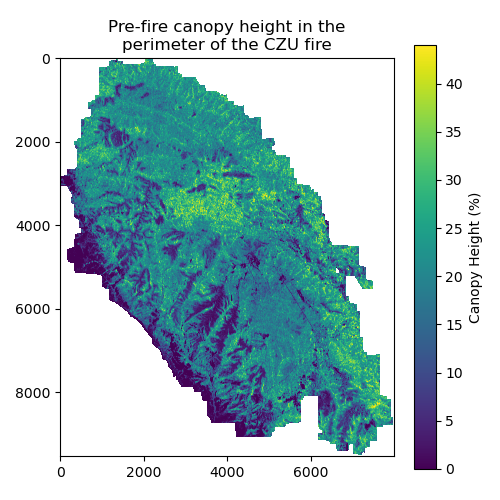

In [9]:
# read and mask the data
ch_ref = gdal.Open(ch_output, gdal.GA_ReadOnly)
band = ch_ref.GetRasterBand(1)
height = ch_ref.ReadAsArray().astype(float)
height[height == band.GetNoDataValue()] = np.nan
ch_ref = None

# get the range to show based on a 2% stretch
vmin = np.nanpercentile(height, 1)
vmax = np.nanpercentile(height, 99)

# and plot
plt.figure(figsize=(5,5), dpi=100)
cover_map = plt.imshow(
    height,
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.viridis,
)
plt.title("Pre-fire canopy height in the\nperimeter of the CZU fire")
colorbar = plt.colorbar(cover_map)
colorbar.set_label("Canopy Height (%)")
plt.tight_layout()

# Section 2: Google Earth Engine

Next, we'll demonstrate how to read and interact with these data in Google Earth Engine. We'll map canopy cover in 2016 and 2020, then compute the change between years with simple band math.

The change map will show areas of canopy loss in warm colors (reds and yellows) and canopy gain in cool colors (blues and greens). These correspond to areas where wildfires and timber harvest removed trees, and to areas where regeneration restored forests.

We only have 3 meter resolution data available for these two years, so we won't specify years in the API search request.

In [10]:
# first we'll get the asset IDs
cc_ids = forest.search(
    geography="California",
    metric="CanopyCover",
    resolution=3,
)
cc_ids.sort()
print(cc_ids)

# get the bucket paths for where each file is stored
cc_bucket_paths = [forest.fetch(cc_id, bucket=True) for cc_id in cc_ids]

['California-Vegetation-CanopyCover-2016-Fall-00003m', 'California-Vegetation-CanopyCover-2020-Spring-00003m']


In [11]:
# read them as earth engine images
cc_2016 = ee.Image.loadGeoTIFF(cc_bucket_paths[0])
cc_2020 = ee.Image.loadGeoTIFF(cc_bucket_paths[1])

# compute the difference between years
change = cc_2020.subtract(cc_2016)

# mask changes below a change detection threshold. We selected 15% because the canopy cover RMSE is ~11%
thresh = 15
mask = change.gt(thresh).Or(change.lt(-thresh))
change = change.mask(mask)

Now that we've loaded the data into Earth Engine and computed the difference between years, we'll create an interactive map to show these data.

In [13]:
# set up visualization parameters
coverViz = {
    "min": 0,
    "max": 90,
    "palette": cfo_green,
}
changeViz = {
    "min": -30,
    "max": 30,
    "palette": cfo_change,
}

# create the notebook map object
mapCenter = [41.2, -123]
m = folium.Map(
    location=mapCenter,
    zoom_start=9,
    tiles="Stamen Toner",
)

# add each layer
m.addLayer(cc_2016, coverViz, "Canopy Cover 2016")
m.addLayer(cc_2020, coverViz, "Canopy Cover 2020")
m.addLayer(change, changeViz, "Change")

# add a color ramp
change_ramp = folium.branca.colormap.LinearColormap(
    cfo_change,
    vmin = -30,
    vmax = 30,
    caption = "% Canopy Cover Change, 2016-2020"
)
change_ramp.add_to(m)

# and add some map controls
m.add_child(folium.LayerControl())
display(m)

I recommend turning the 2020 layer on and off to visualize the change between each years, and to look at change alone on map background.

Don't forget to zoom in--you'll find all sorts of detail.

The final Earth Engine task will be to get the canopy cover pixel value for the tree from the Botanic Garden shown earlier.

In [12]:
# it'll be a simple point lookup
xy = ee.Geometry.Point(pine_coords)
pine_cover = cc_2020.sample(xy, 3).first().get('B0').getInfo()
print(f'Monterey Pine Canopy Cover: {pine_cover}%')

Monterey Pine Canopy Cover: 59%


# Section 3: STAC search

Our final demo will be brief, and relates to querying the Forest Observatory datasets via an emerging geospatial data indexing standard, STAC.

We'll just run through a couple of example functions for working with the Forest Observatory STAC catalog.

In [14]:
# set and read the catalog
catalog_url = "https://storage.googleapis.com/cfo-public/catalog.json"
catalog = pystac.Catalog.from_file(catalog_url)

# what's in this catalog?
print(catalog.description)

# iteratively retrieve the items within the catalog
print("\nCatalog contents:")
print(catalog.describe())

The California Forest Observatory is a data-driven forest monitoring system that maps the drivers of wildfire behavior across the state-including vegetation fuels, weather, topography & infrastructure-from space.

Catalog contents:
* <Catalog id=forest-observatory>
    * <Collection id=vegetation>
      * <Item id=California-Vegetation-CanopyBaseHeight-2016-Summer-00010m>
      * <Item id=California-Vegetation-CanopyBaseHeight-2017-Summer-00010m>
      * <Item id=California-Vegetation-CanopyBaseHeight-2018-Summer-00010m>
      * <Item id=California-Vegetation-CanopyBaseHeight-2019-Summer-00010m>
      * <Item id=California-Vegetation-CanopyBaseHeight-2020-Summer-00010m>
      * <Item id=California-Vegetation-CanopyBulkDensity-2016-Summer-00010m>
      * <Item id=California-Vegetation-CanopyBulkDensity-2017-Summer-00010m>
      * <Item id=California-Vegetation-CanopyBulkDensity-2018-Summer-00010m>
      * <Item id=California-Vegetation-CanopyBulkDensity-2019-Summer-00010m>
      * <Item

There's only one colletion within this catalog now, which you see at the top of the `.describe()` output. We can use the `id` of this collection to retrieve it, then query the collection for more information

In [15]:
veg = catalog.get_child('vegetation')
items = veg.get_all_items()
print(veg.description)

print(f"\nThere are {len(list(items))} items in this collection:")
for item in veg.get_all_items():
    metric = item.properties['metric']
    units = item.properties['units']
    resolution = item.properties['gsd']
    date = item.get_datetime()
    print(f"{date.year} {metric} - {units} - {resolution}m gsd")

Patterns of forest structure and forest fuels that drive wildfire behavior. Read more at https://forestobservatory.com/about.html

There are 39 items in this collection:
2016 CanopyBaseHeight - meters - 10m gsd
2017 CanopyBaseHeight - meters - 10m gsd
2018 CanopyBaseHeight - meters - 10m gsd
2019 CanopyBaseHeight - meters - 10m gsd
2020 CanopyBaseHeight - meters - 10m gsd
2016 CanopyBulkDensity - kilograms per cubic meter - 10m gsd
2017 CanopyBulkDensity - kilograms per cubic meter - 10m gsd
2018 CanopyBulkDensity - kilograms per cubic meter - 10m gsd
2019 CanopyBulkDensity - kilograms per cubic meter - 10m gsd
2020 CanopyBulkDensity - kilograms per cubic meter - 10m gsd
2016 CanopyCover - percent - 10m gsd
2016 CanopyCover - percent - 10m gsd
2017 CanopyCover - percent - 10m gsd
2018 CanopyCover - percent - 10m gsd
2019 CanopyCover - percent - 10m gsd
2020 CanopyCover - percent - 10m gsd
2020 CanopyCover - percent - 10m gsd
2016 CanopyHeight - meters - 10m gsd
2016 CanopyHeight - mete

Each item in this dictionary stores information on what spatial extent it covers, the time and date of collection, as well as links to related objects.

In [16]:
# each item contains a lot of information, which you can easily retrieve
item.to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0-beta.2',
 'id': 'California-Vegetation-SurfaceFuels-2020-Summer-00010m',
 'properties': {'metric': 'SurfaceFuels',
  'sci:rmse': None,
  'sci:mae': None,
  'sci:rsquared': None,
  'units': 'categorical',
  'gsd': 10,
  'datetime': '2020-07-15T18:00:00Z'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-119.63473135373151, 33.265446693634125],
     [-119.52532534139888, 33.334866706974005],
     [-119.36071430612228, 33.22145670358109],
     [-119.5102623262436, 33.167421689750796],
     [-119.63473135373151, 33.265446693634125]]],
   [[[-118.67485517813442, 33.012147716854926],
     [-118.5421151607102, 33.07379273074079],
     [-118.29585309951715, 32.79826071238778],
     [-118.46472412491727, 32.76018069936904],
     [-118.67485517813442, 33.012147716854926]]],
   [[[-119.10722728621582, 33.500027747508405],
     [-119.00807927290442, 33.537559757007664],
     [-118.96376326013716, 33.466834751707424],
     [-119.07190527376416

Within each of these items can be a nested set of assets, which contain paths to the sources of the geospatial data.

In [ ]:
# I've found this to be a rather circuitous route to getting asset data..
assets = item.get_assets()
asset_keys = assets.keys()
for key in asset_keys:
    asset = assets[key]
    print(asset)

# Conclusion

Thanks for following along with us. We're working hard to make sure our data are easy to access, use & understand, all in service of trying to support California's conservation and climate change mitigation goals.

Please visit the Forest Observatory [user forums](https://groups.google.com/a/forestobservatory.com/g/community?pli=1) or [get in touch](mailto:tech@forestobservatory.com) if you have any questions.